find size of embedding (last layer of model) for each saved model

preprocess lvl embedding size


In [1]:
import torch
import timm
import sys
sys.path.append('..')
from models.fusion_model import FusionModel
from models.resnet_plus_model import ResNetPlusModel
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from data.wildlife_dataset import WildlifeDataModule
from wildlife_datasets import analysis, datasets, loader
from data.raptors_wildlife import Raptors


import yaml

# Load config from file
with open("/Users/amee/Documents/code/master-thesis/EagleID/configs/config-hpc-raptors.yml", "r") as f:
    config = yaml.safe_load(f)
# create a config dict
# config = {}
# config['wildlife_name'] = 'raptors'
# config['animal_cat'] = 'bird'
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/raptor_individuals_cropped'
config['cache_path']= '/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_raptors_split.csv' #  CACHE
config['preprocess_lvl'] = 3 # PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
# config['img_size'] =224
# config['transforms'] = {}
# config['transforms']['mean'] = [0.485, 0.456, 0.406]
# config['transforms']['std'] = [0.229, 0.224, 0.225]
# config['split_ratio'] = 0.8
config['splitter'] = 'metadata_split' # CUSTOM CLOSED / metadata
# config['only_cache'] = False # FALSE
# config['arcface_loss'] = {}
# config['arcface_loss']['n_classes'] = 0
config['custom_transform'] = True
# config['use_gradcam'] = False


dataset = Raptors(root=config['dataset'])
dataset.df['wildlife_name'] = 'raptors'
data = WildlifeDataModule(metadata=dataset.df, config = config)

# Path to the saved checkpoint
ckpt_path = "/Users/amee/Documents/code/master-thesis/EagleID/checkpoints/model-7vv8ip2a.ckpt"

model = ResNetPlusModel.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    config=config,
    pretrained=False
)
print('in_channels: ',model.backbone.conv1.in_channels)
checkpoint = torch.load(ckpt_path)

model.eval()  # ensure eval mode

trainer = Trainer(accelerator="cpu")
trainer.validate(model, dataloaders=data.val_dataloader())

/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Dataset size before pre-processing and cleaning: 509
Removed 0 rows with invalid segmentation data.
Split: closed-set
Samples: train/test/unassigned/total = 382/127/0/509
Classes: train/test/unassigned/total = 69/53/0/69
Classes: train only/test only/joint  = 16/0/53

Fraction of train set     = 75.05%
Fraction of test set only = 0.00%
Training Set
Length: 382
Number of individuals (classes): 69
Mean images/individual: 5.536231884057971
Min images/individual: 2
Max images/individual: 48
Test Set
Length: 127
Number of individuals (classes): 53
Mean images per individual: 2.3962264150943398
Min images per individual: 1
Max images per individual: 8
Loaded mask cache from ../dataset/data_cache/train_raptors_mask.npz: Masks count: 369


/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../data/wildlife_dataset.py:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['query'] = df_test['query'].astype(bool)


Loaded primary cache from ../dataset/data_cache/train_raptors_skeleton.npz: Skeleton: 369
Precomputed data loaded from bbox_mask_skeleton for train_raptors. Only to be used for processing lvl 2-5
Loaded mask cache from ../dataset/data_cache/query_raptors_mask.npz: Masks count: 49
Loaded primary cache from ../dataset/data_cache/query_raptors_skeleton.npz: Skeleton: 49
Precomputed data loaded from bbox_mask_skeleton for query_raptors. Only to be used for processing lvl 2-5
Loaded mask cache from ../dataset/data_cache/gallery_raptors_mask.npz: Masks count: 78
Loaded primary cache from ../dataset/data_cache/gallery_raptors_skeleton.npz: Skeleton: 78
Precomputed data loaded from bbox_mask_skeleton for gallery_raptors. Only to be used for processing lvl 2-5


/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


RuntimeError: Error(s) in loading state_dict for ResNetPlusModel:
	Missing key(s) in state_dict: "loss_fn.W". 

In [18]:
# Get the list of DataLoaders (query and gallery)
val_loaders = data.val_dataloader()

# Access the Query DataLoader
query_loader = val_loaders[0]

# Extract a batch from the Query DataLoader
query_batch = next(iter(query_loader))

# Check how many elements are in the batch
print("Number of elements in batch:", len(query_batch))

# Adjust unpacking based on the batch structure (images, labels)
x, y = query_batch

# Forward pass to get output shape
model.eval()
with torch.no_grad():
    output = model(x)

print("Output shape:", output.shape)  # Should print (batch_size, embedding_size)

Number of elements in batch: 2
Output shape: torch.Size([4, 128])


Print predictions for model

In [19]:
from utils.triplet_loss_utils import KnnClassifier
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.features import DeepFeatures

from sklearn.metrics import precision_score, recall_score, f1_score
from utils.visualization import query_prediction_results_similarity
import numpy as np


In [20]:
# Evaluate the model in retrieval metrics -- ONLY ONE SPECIES IN DATASET ALREADY (NO FILTERING REQUIRED)
# dataset_database_P = WildlifeDataset(metadata.df.iloc[100:,:], metadata.root, transform=transform)
# dataset_query_P = WildlifeDataset(metadata.df.iloc[:100,:], metadata.root, transform=transform)
dataset_query_P = data.val_query_dataset
dataset_database_P = data.val_gallery_dataset

# name = 'hf-hub:BVRA/MegaDescriptor-T-224'
extractor_P = DeepFeatures(model , device = 'cpu')

query_P, database_P = extractor_P(dataset_query_P), extractor_P(dataset_database_P)

similarity_function = CosineSimilarity()
similarity_P = similarity_function(query_P, database_P)
print(similarity_P)
classifier_P = KnnClassifier(k=1, database_labels=dataset_database_P.labels_string)
predictions_P = classifier_P(similarity_P['cosine'])
print("Predictions for 100 test Images:-\n",predictions_P)
accuracy_P = np.mean(dataset_query_P.labels_string == predictions_P)
print("Accuracy: {:.2f}%".format(accuracy_P * 100))

precision_P = precision_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
recall_P = recall_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
f1_P = f1_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
print("Precision:", precision_P)
print("Recall:", recall_P)
print("F1 Score:", f1_P)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.42s/it]

{'cosine': array([[ 0.8746631 ,  0.46505708,  0.42394385, ...,  0.8757773 ,
         0.33676684, -0.7084092 ],
       [ 0.5592804 ,  0.91528946,  0.93828565, ...,  0.5564125 ,
         0.9661575 ,  0.6225354 ],
       [ 0.2532197 ,  0.7360814 ,  0.7708305 , ...,  0.25020257,
         0.82549864,  0.84521306],
       ...,
       [ 0.9462284 ,  0.61194706,  0.5747042 , ...,  0.9469324 ,
         0.4954405 , -0.57585114],
       [ 0.9183883 ,  0.5491179 ,  0.5099808 , ...,  0.9195568 ,
         0.42665493, -0.637506  ],
       [ 0.8318452 ,  1.0000002 ,  0.9936341 , ...,  0.8300024 ,
         0.98727214,  0.28510058]], dtype=float32)}
19
93
Predictions for 100 test Images:-
 ['SouthScotland_heatherF05' 'England_022' 'BigBear_shadow' 'Orrhult_269K'
 'England_G318' 'England_G461' 'SouthScotland_shineB44' 'Alabama_natchez'
 'England_G818' 'England_G463' 'England_G818' 'England_G818'
 'SouthScotland_emily121' 'BigBear_jackie' 'SouthScotland_mapleF24'
 'England_022' 'SouthScotland_skanC17' 'So


/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


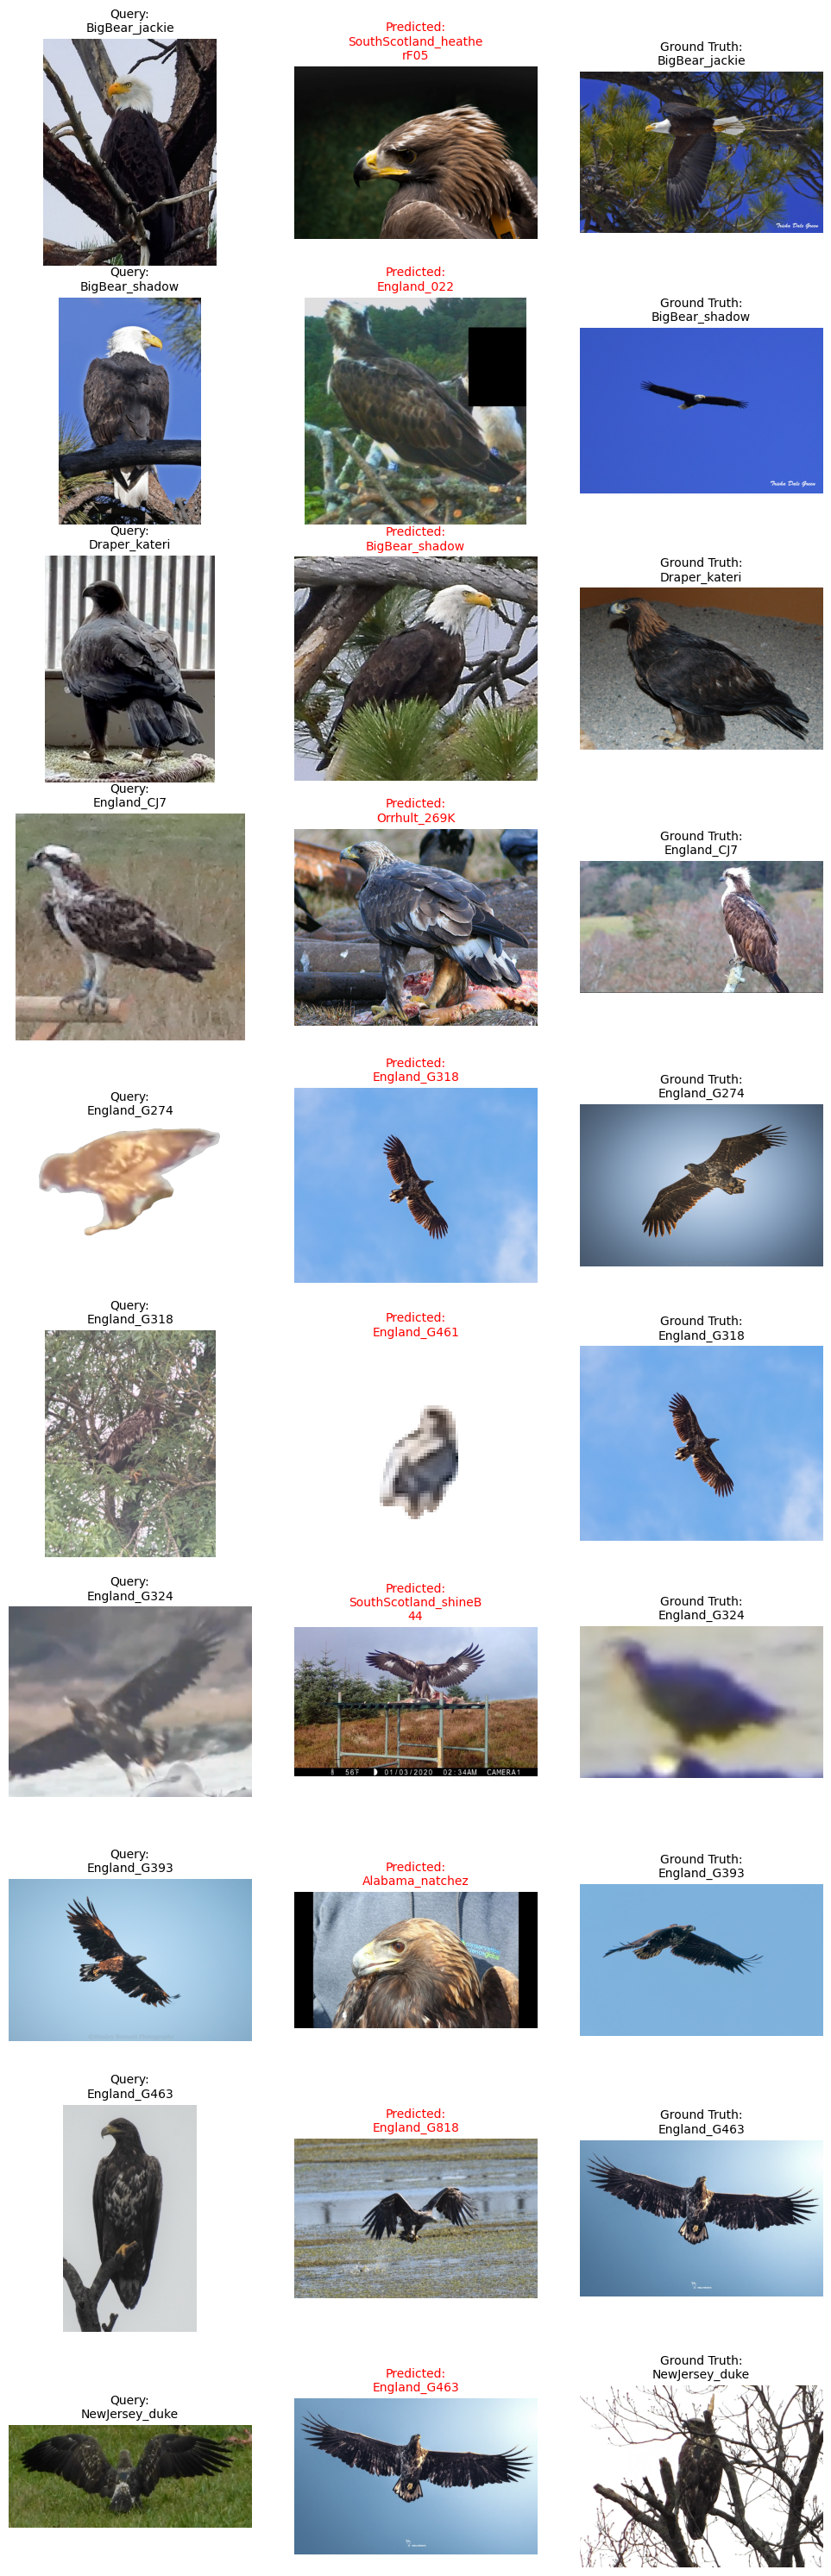

In [21]:
# prediction for dataset with just one species
query_prediction_results_similarity(
    root=config['dataset'],
    query_metadata=dataset_query_P.metadata,
    db_metadata=dataset_database_P.metadata,
    query_start=0,
    similarity_scores=similarity_P['cosine'],
    num_images=10
)